In [45]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from SALib.sample import saltelli
from SALib.analyze import sobol
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


### 1. Calculate Annuities and Insurance Premiums

In [46]:
# Example life table for ages 18-59
life_table = pd.DataFrame({
    'age': np.arange(18, 60),
    'qx': np.random.uniform(0.001, 0.02, 42),  # Mortality rates between 0.1% and 2%
    'lx': np.random.randint(10000, 50000, 42)   # Survivors at the start of each age group
})
life_table

,age,qx,lx
0,18,0.001041,15873
1,19,0.005053,16900
2,20,0.015469,15745
3,21,0.010810,48194
4,22,0.012583,26575
5,23,0.016409,46130
6,24,0.004967,32945
7,25,0.015048,14525
8,26,0.009088,42404
9,27,0.007590,42244


In [47]:
# Policy parameters
death_benefit = 500000  # £500,000 policy
interest_rate = 0.03    # 3% interest rate (annual)
error_margin = 0.05     # 5% error margin for sensitivity analysis
year = 5                 # number of years of coverage

def calculate_premium(life_table, interest_rate, death_benefit):
    # Calculate present value of death benefit at each age
    life_table['premium'] = 0.0
    for idx, row in life_table.iterrows():
        age = row['age']
        qx = row['qx']
        
        # Calculate the discount factor for the age (assuming annual discount)
        discount_factor = 1 / (1 + interest_rate) ** (age - 18)  # Assume 18 is the starting age
        
        # Calculate the expected death benefit discounted
        life_table.loc[idx, 'premium']  = death_benefit * qx * discount_factor/year #present_value_death_benefit
    
    return life_table['premium'].mean()

premium = calculate_premium(life_table, interest_rate, death_benefit)
print(f"Calculated Avearge Annual Premium: £{premium:,.2f}")
life_table


Calculated Avearge Annual Premium: £627.41


,age,qx,lx,premium
0,18,0.001041,15873,104.066747
1,19,0.005053,16900,490.541456
2,20,0.015469,15745,1458.086611
3,21,0.010810,48194,989.253333
4,22,0.012583,26575,1117.956026
5,23,0.016409,46130,1415.469092
6,24,0.004967,32945,415.946585
7,25,0.015048,14525,1223.518632
8,26,0.009088,42404,717.426883
9,27,0.007590,42244,581.705790


### 2. Analyse the risks for insurance policies above

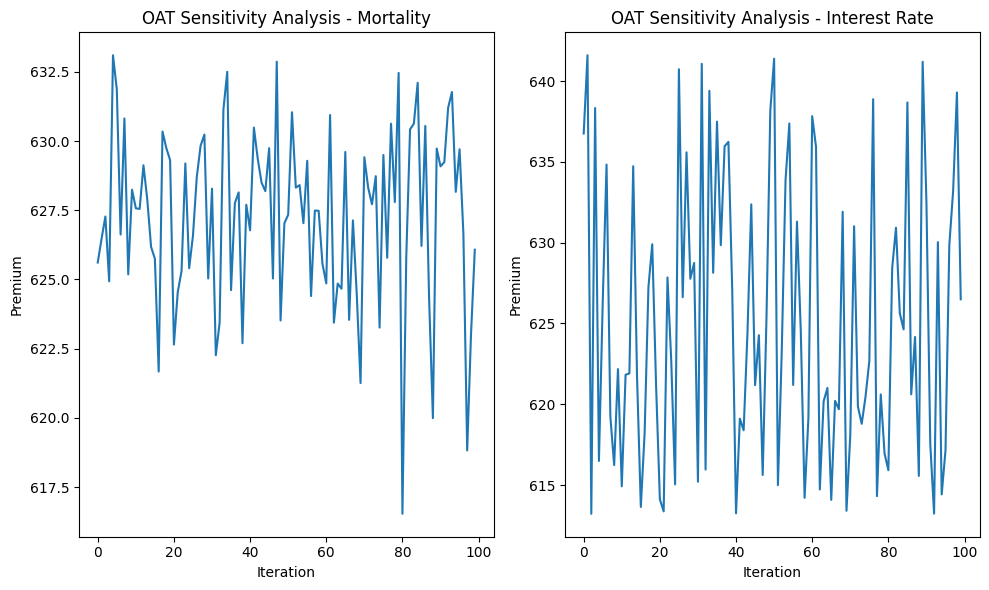

baseline premium: 627.410311705474
Standard deviation for varying death probability: 3.137067666535804
Standard deviation for varying interest rate: 8.620443803476277


In [53]:
# OAT Sensitivity Analysis
def oat_sensitivity_analysis(life_table, interest_rate, death_benefit, error_margin):
    # Perturb the mortality rate and interest rate one at a time
    premium_baseline = calculate_premium(life_table, interest_rate, death_benefit)
    premiums_mortality = []
    premiums_interest = []
    
    # Vary mortality rate
    for i in range(100):
        adjusted_life_table = life_table.copy()
        mortality_rate_change = np.random.uniform(-error_margin, error_margin, len(adjusted_life_table))
        adjusted_life_table['qx'] *= (1 + mortality_rate_change)
        premiums_mortality.append(calculate_premium(adjusted_life_table, interest_rate, death_benefit))
    
    # Vary interest rate
    for i in range(100):
        adjusted_interest_rate = interest_rate * (1 + np.random.uniform(-error_margin, error_margin))
        premiums_interest.append(calculate_premium(life_table, adjusted_interest_rate, death_benefit))
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(premiums_mortality)
    plt.title("OAT Sensitivity Analysis - Mortality")
    plt.xlabel("Iteration")
    plt.ylabel("Premium")
    
    plt.subplot(1, 2, 2)
    plt.plot(premiums_interest)
    plt.title("OAT Sensitivity Analysis - Interest Rate")
    plt.xlabel("Iteration")
    plt.ylabel("Premium")
    
    plt.tight_layout()
    plt.show()
    
    print("baseline premium:", premium_baseline)
    print("Standard deviation for varying death probability:", np.std(premiums_mortality))
    print("Standard deviation for varying interest rate:", np.std(premiums_interest))

oat_sensitivity_analysis(life_table, interest_rate, death_benefit, error_margin)

In [51]:
# Sobol Indices Sensitivity Analysis
def sobol_sensitivity_analysis(life_table, interest_rate, death_benefit, error_margin):
    # Define the problem: change in mortality rates (qx) and interest rate (r)
    problem = {
        'num_vars': 2,
        'names': ['mortality_rate', 'interest_rate'],
        'bounds': [[-error_margin, error_margin], [-error_margin, error_margin]]
    }
    
    # Define input sample space
    param_values = saltelli.sample(problem, 1000, calc_second_order=True)
    
    # Perform Sobol sensitivity analysis
    Y = []
    for params in param_values:
        mortality_rate_change, interest_rate_change = params
        # Adjust life table mortality rates based on sensitivity factor
        adjusted_life_table = life_table.copy()
        adjusted_life_table['qx'] *= (1 + mortality_rate_change)
        
        # Adjust interest rate
        adjusted_interest_rate = interest_rate * (1 + interest_rate_change)
        
        # Recalculate premium with adjusted parameters
        premium = calculate_premium(adjusted_life_table, adjusted_interest_rate, death_benefit)
        Y.append(premium)
    
    Y = np.array(Y)
    Si = sobol.analyze(problem, Y)
    return Si

sobol_result = sobol_sensitivity_analysis(life_table, interest_rate, death_benefit, error_margin)
print("First Order Indices:", sobol_result['S1'])
print("Total Order Indices:", sobol_result['ST'])



C:\Users\xiang\AppData\Local\Temp\ipykernel_10860\2107922552.py:11: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1000, calc_second_order=True)
C:\Users\xiang\AppData\Roaming\Python\Python312\site-packages\SALib\sample\saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


First Order Indices: [0.81210318 0.18974797]
Total Order Indices: [0.80978781 0.18822409]


C:\Users\xiang\AppData\Roaming\Python\Python312\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [54]:
# Regression-based Sensitivity Analysis
def regression_sensitivity_analysis(life_table, interest_rate, death_benefit, error_margin):
    # Create input variables (mortality rates and interest rates)
    mortality_rates = life_table['qx'].values
    interest_rates = np.full_like(mortality_rates, interest_rate)
    
    # Generate data by perturbing mortality rates and interest rate
    mortality_rate_change = np.random.uniform(-error_margin, error_margin, len(mortality_rates))
    interest_rate_change = np.random.uniform(-error_margin, error_margin, len(mortality_rates))
    
    X = np.vstack([mortality_rate_change, interest_rate_change]).T
    Y = []
    
    for i in range(len(mortality_rates)):
        # Adjust the life table and interest rate
        adjusted_life_table = life_table.copy()
        adjusted_life_table['qx'] *= (1 + mortality_rate_change[i])
        
        adjusted_interest_rate = interest_rate * (1 + interest_rate_change[i])
        
        # Calculate premium
        premium = calculate_premium(adjusted_life_table, adjusted_interest_rate, death_benefit)
        Y.append(premium)
    
    Y = np.array(Y)
    
    # Perform regression to analyze the sensitivity
    model = LinearRegression()
    model.fit(X, Y)
    
    sensitivity = model.coef_
    return sensitivity

regression_sensitivity = regression_sensitivity_analysis(life_table, interest_rate, death_benefit, error_margin)
print(f"Regression-based Sensitivity Analysis Coefficients: {regression_sensitivity}")



Regression-based Sensitivity Analysis Coefficients: [ 627.11271175 -301.78742848]


The regression line suggests the most probable linear relationship between the premium and [mortality, interest rate] is：

Premium = [ 627 -302] $ \begin{bmatrix} p \\ r \end{bmatrix} $